# Train MO Model
This notebook will develop and train a neural network to predict the percent change in the MO price.
It will utilize grid search to find the best hyperparameters

## Enviornment setups

In [2]:
# Import packages

# General Utility
from datetime import datetime
import datetime, time
from datetime import timedelta

# Data processing
import numpy as np
import pandas as pd
import pickle
from sklearn.preprocessing import RobustScaler

# Plotting
import matplotlib.pyplot as plt

import torch

# Diamond-Hands
import sys
sys.path.append('../Packages/')
import diamond_hands as dh

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\ntnay\AppData\Roaming\nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [3]:
tickr = 'MO'

In [4]:
# Data Locations
processed_input_dir = '../../Data/ProcessedInputs/'
model_dir = '../../Data/Models/'
grid_result_dir = model_dir+tickr+'/'
fine_grid_result_dir = model_dir+tickr+'/Fine/'
pred_dir = '../../Data/Predictions/'
final_model_dir = '../../Data/Models/Final/'

In [5]:
TRAIN_ON_GPU, TRAIN_ON_MULTI_GPUS = dh.setupPytorch()

Training on GPU!


In [6]:
with open(processed_input_dir+tickr+'_input_data.bin','rb') as f:
    df = pickle.load(f)
with open(processed_input_dir+tickr+'_output_data.bin','rb') as f:
    output_data = pickle.load(f)
with open(model_dir+tickr+'_scaler.bin','rb') as f:
    scaler = pickle.load(f)

In [7]:
df = df[:-1]

In [8]:
df['2021-03-01':]

,P_Change,volume_adi,volume_obv,volume_cmf,volume_fi,volume_mfi,volume_em,volume_sma_em,volume_vpt,volume_nvi,...,Tomorrow_Tickr_#Pos,Tomorrow_Tickr_W#Neg,Tomorrow_Tickr_W#Neu,Tomorrow_Tickr_W#Pos,Tomorrow_Tickr_%Neg,Tomorrow_Tickr_%Neu,Tomorrow_Tickr_%Pos,Tomorrow_Tickr_W%Neg,Tomorrow_Tickr_W%Neu,Tomorrow_Tickr_W%Pos
Date,,,,,,,,,,,,,,,,,,,,,
2021-03-01,0.681159,0.883521,0.811853,-0.078458,-0.035774,0.551067,1.503265,0.718604,-0.697470,3.611645,...,0.0,2.0,0.0,0.0,1.000000,0.000000,0.000000,1.000000,0.000000,0.000000
2021-03-02,0.122962,0.879587,0.815210,-0.079110,0.052070,0.556848,0.404304,0.707104,1.123361,3.628615,...,1.0,0.0,9.0,4.0,0.000000,0.800000,0.200000,0.000000,0.692308,0.307692
2021-03-03,0.452117,0.877745,0.819418,-0.299117,0.253002,0.594947,0.672018,0.665432,0.522287,3.628615,...,2.0,0.0,3.0,6.0,0.000000,0.333333,0.666667,0.000000,0.333333,0.666667
2021-03-04,-0.611089,0.865150,0.813867,-0.705428,-0.499928,0.437777,-0.842253,0.572445,-0.935872,3.628615,...,3.0,0.0,4.0,20.0,0.000000,0.250000,0.750000,0.000000,0.166667,0.833333
2021-03-05,1.159449,0.874065,0.818812,-0.690633,0.238790,0.740196,0.032818,0.646069,-0.080878,3.710532,...,2.0,0.0,15.0,5.0,0.000000,0.666667,0.333333,0.000000,0.750000,0.250000
2021-03-08,2.142705,0.891681,0.825867,-0.198436,2.202931,0.831894,3.393670,1.219358,4.858243,3.710532,...,0.0,2.0,6.0,0.0,0.333333,0.666667,0.000000,0.250000,0.750000,0.000000
2021-03-09,1.492273,0.901141,0.831517,-0.036234,2.580281,0.894403,2.972282,1.652951,4.830444,3.782010,...,2.0,9.0,5.0,4.0,0.200000,0.400000,0.400000,0.500000,0.277778,0.222222
2021-03-10,0.037808,0.904744,0.835593,-0.066545,2.537177,0.922777,1.306484,1.811263,1.755499,3.829662,...,0.0,0.0,15.0,0.0,0.000000,1.000000,0.000000,0.000000,1.000000,0.000000
2021-03-11,0.096242,0.894762,0.831829,-0.214451,1.919331,0.666258,-0.030194,1.826641,0.109397,3.793006,...,3.0,0.0,14.0,9.0,0.000000,0.400000,0.600000,0.000000,0.608696,0.391304


In [9]:
n_test=37

## Grid Search

In [9]:
# Configure search space
n_features = [df.shape[1]]
n_periods = [1,5,10,20,40,60]
n_hidden = [10,50,100]
n_layers = [2,3]
drop_prob = [0.1,0.25,0.5]
lr = [0.001,0.01]
clip = [1,5,10]
batch_size = [400]

In [10]:
# use grid search to optimize hyperparameters
grid_result = []
dh.gridSearch(grid_results = grid_result,
              tickr=tickr,
                           n_features=n_features,
                           n_periods=n_periods,
                           n_hidden=n_hidden,
                           n_layers=n_layers,
                           drop_prob=drop_prob,
                           lr=lr,
                           clip=clip,
                           batch_size=batch_size,
                           data=df,
                           epochs=10,
                           n_test=n_test,
                           n_steps_out=1,
                          fpath=grid_result_dir,
                           TRAIN_ON_GPU=TRAIN_ON_GPU,
                           TRAIN_ON_MULTI_GPUS=TRAIN_ON_MULTI_GPUS)

Hyper Parameter search across 648 different configurations.
Iteration: 1 |periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1


C:\Environments\python37\lib\site-packages\torch\cuda\nccl.py:16: UserWarning: PyTorch is not compiled with NCCL support
  warnings.warn('PyTorch is not compiled with NCCL support')


Training complete in 0m 30s
Iteration: 2 |periods: 5|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 12s
Iteration: 3 |periods: 10|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 16s
Iteration: 4 |periods: 20|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 20s
Iteration: 5 |periods: 40|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 29s
Iteration: 6 |periods: 60|hidden: 10|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 42s
Iteration: 7 |periods: 1|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 13s
Iteration: 8 |periods: 5|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 17s
Iteration: 9 |periods: 10|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 18s
Iteration: 10 |periods: 20|hidden: 50|layers: 2|drop: 0.1|lr: 0.001|clip: 1
Training complete in 0m 22s
Iteration: 11 |periods: 40|hidden: 50|layers: 2

Training complete in 0m 17s
Iteration: 81 |periods: 10|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 20s
Iteration: 82 |periods: 20|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 23s
Iteration: 83 |periods: 40|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 30s
Iteration: 84 |periods: 60|hidden: 50|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 43s
Iteration: 85 |periods: 1|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 13s
Iteration: 86 |periods: 5|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 17s
Iteration: 87 |periods: 10|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 20s
Iteration: 88 |periods: 20|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 26s
Iteration: 89 |periods: 40|hidden: 100|layers: 2|drop: 0.5|lr: 0.001|clip: 1
Training complete in 0m 37s
Iteration: 90 |periods: 60|hidden

Training complete in 0m 20s
Iteration: 160 |periods: 20|hidden: 100|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 26s
Iteration: 161 |periods: 40|hidden: 100|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 37s
Iteration: 162 |periods: 60|hidden: 100|layers: 2|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 51s
Iteration: 163 |periods: 1|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 14s
Iteration: 164 |periods: 5|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 18s
Iteration: 165 |periods: 10|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 23s
Iteration: 166 |periods: 20|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 34s
Iteration: 167 |periods: 40|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 0m 49s
Iteration: 168 |periods: 60|hidden: 10|layers: 3|drop: 0.25|lr: 0.01|clip: 1
Training complete in 1m 7s
Iteration: 169 |periods: 1|

Training complete in 0m 34s
Iteration: 239 |periods: 40|hidden: 10|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 50s
Iteration: 240 |periods: 60|hidden: 10|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 1m 7s
Iteration: 241 |periods: 1|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 15s
Iteration: 242 |periods: 5|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 19s
Iteration: 243 |periods: 10|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 25s
Iteration: 244 |periods: 20|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 35s
Iteration: 245 |periods: 40|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 53s
Iteration: 246 |periods: 60|hidden: 50|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 1m 10s
Iteration: 247 |periods: 1|hidden: 100|layers: 3|drop: 0.1|lr: 0.001|clip: 5
Training complete in 0m 16s
Iteration: 248 |periods: 5|hid

Training complete in 0m 36s
Iteration: 317 |periods: 40|hidden: 50|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 55s
Iteration: 318 |periods: 60|hidden: 50|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 1m 14s
Iteration: 319 |periods: 1|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 17s
Iteration: 320 |periods: 5|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 22s
Iteration: 321 |periods: 10|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 26s
Iteration: 322 |periods: 20|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 38s
Iteration: 323 |periods: 40|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 0m 57s
Iteration: 324 |periods: 60|hidden: 100|layers: 3|drop: 0.5|lr: 0.001|clip: 5
Training complete in 1m 13s
Iteration: 325 |periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 0m 13s
Iteration: 326 |periods: 

Training complete in 0m 56s
Iteration: 396 |periods: 60|hidden: 100|layers: 3|drop: 0.25|lr: 0.01|clip: 5
Training complete in 1m 11s
Iteration: 397 |periods: 1|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 13s
Iteration: 398 |periods: 5|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 16s
Iteration: 399 |periods: 10|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 18s
Iteration: 400 |periods: 20|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 23s
Iteration: 401 |periods: 40|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 29s
Iteration: 402 |periods: 60|hidden: 10|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 38s
Iteration: 403 |periods: 1|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 13s
Iteration: 404 |periods: 5|hidden: 50|layers: 2|drop: 0.5|lr: 0.01|clip: 5
Training complete in 0m 16s
Iteration: 405 |periods: 10|hidden: 50

Training complete in 0m 29s
Iteration: 474 |periods: 60|hidden: 10|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 39s
Iteration: 475 |periods: 1|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 13s
Iteration: 476 |periods: 5|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 16s
Iteration: 477 |periods: 10|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 18s
Iteration: 478 |periods: 20|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 23s
Iteration: 479 |periods: 40|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 31s
Iteration: 480 |periods: 60|hidden: 50|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 40s
Iteration: 481 |periods: 1|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 13s
Iteration: 482 |periods: 5|hidden: 100|layers: 2|drop: 0.25|lr: 0.001|clip: 10
Training complete in 0m 17s
Iteration: 

Training complete in 0m 40s
Iteration: 552 |periods: 60|hidden: 50|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 53s
Iteration: 553 |periods: 1|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 17s
Iteration: 554 |periods: 5|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 22s
Iteration: 555 |periods: 10|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 25s
Iteration: 556 |periods: 20|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 31s
Iteration: 557 |periods: 40|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 46s
Iteration: 558 |periods: 60|hidden: 100|layers: 2|drop: 0.1|lr: 0.01|clip: 10
Training complete in 1m 0s
Iteration: 559 |periods: 1|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 17s
Iteration: 560 |periods: 5|hidden: 10|layers: 3|drop: 0.1|lr: 0.01|clip: 10
Training complete in 0m 23s
Iteration: 561 |periods: 1

Training complete in 0m 45s
Iteration: 630 |periods: 60|hidden: 100|layers: 2|drop: 0.5|lr: 0.01|clip: 10
Training complete in 1m 0s
Iteration: 631 |periods: 1|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 17s
Iteration: 632 |periods: 5|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 23s
Iteration: 633 |periods: 10|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 30s
Iteration: 634 |periods: 20|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 40s
Iteration: 635 |periods: 40|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 1m 0s
Iteration: 636 |periods: 60|hidden: 10|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 1m 20s
Iteration: 637 |periods: 1|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 18s
Iteration: 638 |periods: 5|hidden: 50|layers: 3|drop: 0.5|lr: 0.01|clip: 10
Training complete in 0m 24s
Iteration: 639 |periods: 10|hidd

In [11]:
with open(model_dir+tickr+'_grid_search_result.bin','wb') as f:
    pickle.dump(grid_result,f)

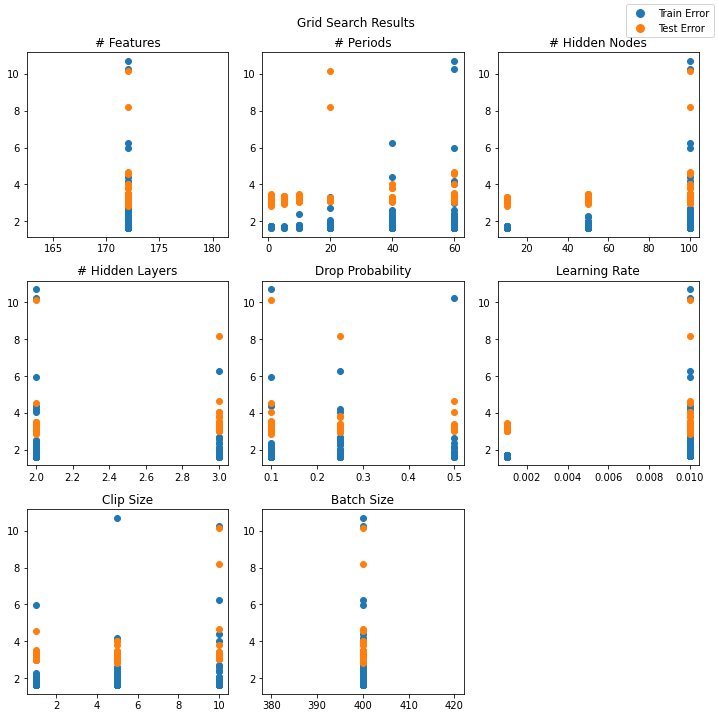

In [12]:
dh.visualizeGridSearch(grid_result)

In [13]:
resultdf = dh.resultDF(grid_result)

In [14]:
sorted_results = resultdf.sort_values(by=['Test Error'])
sorted_results

,Train Error,Test Error,# Features,# Periods,# Hidden Nodes,# Hidden Layers,Drop Probability,Learning Rate,Clip Size,Batch Size
324,1.677248,2.837134,172.0,1.0,10.0,2.0,0.10,0.01,5.0,400.0
367,1.678636,2.960045,172.0,5.0,50.0,2.0,0.25,0.01,5.0,400.0
390,1.679048,2.986699,172.0,1.0,100.0,3.0,0.25,0.01,5.0,400.0
126,1.677493,3.004103,172.0,1.0,10.0,3.0,0.10,0.01,1.0,400.0
121,1.666780,3.009231,172.0,5.0,100.0,2.0,0.10,0.01,1.0,400.0
...,...,...,...,...,...,...,...,...,...,...
358,1.759882,4.038277,172.0,40.0,100.0,3.0,0.10,0.01,5.0,400.0
125,5.969646,4.552548,172.0,60.0,100.0,2.0,0.10,0.01,1.0,400.0
647,2.627354,4.668407,172.0,60.0,100.0,3.0,0.50,0.01,10.0,400.0
609,2.693881,8.184771,172.0,20.0,100.0,3.0,0.25,0.01,10.0,400.0


## Fine Grid Search

In [15]:
best_model_id = sorted_results.index[0]

In [16]:
with open(grid_result_dir+str(best_model_id+1)+'.model','rb') as f:
    model = torch.load(f)
model.eval()


StockLSTM(
  (lstm): LSTM(172, 10, num_layers=2, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

In [17]:
# Configure search space
n_features = [df.shape[1]]
n_periods = [model.n_periods]
n_hidden = [model.n_hidden]
n_layers = [model.n_layers]
drop_prob = [model.drop_prob]
lr = [model.lr]
clip = [model.clip]
#batch_size = [1,5,10,20,40,60,120,240]
batch_size = [4,20,40,80,240,480,960]
epochs = [10,25,50,100,250,500]

In [20]:
batch_size = [20,40,80,240,480,960]
epochs = [50,100,250,500]

In [21]:
# use fine grid search to optimize hyperparameters
#fine_grid_result = []
dh.finegridSearch(grid_results = fine_grid_result,
              tickr=tickr,
                           n_features=n_features,
                           n_periods=n_periods,
                           n_hidden=n_hidden,
                           n_layers=n_layers,
                           drop_prob=drop_prob,
                           lr=lr,
                           clip=clip,
                           batch_size=batch_size,
                           data=df,
                           epochs=epochs,
                           n_test=n_test,
                           n_steps_out=1,
                          fpath=fine_grid_result_dir,
                           TRAIN_ON_GPU=TRAIN_ON_GPU,
                           TRAIN_ON_MULTI_GPUS=TRAIN_ON_MULTI_GPUS)

Hyper Parameter search across 24 different configurations.
Iteration: 1 |epochs: 50|periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 20m 59s
Iteration: 2 |epochs: 50|periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 10m 55s
Iteration: 3 |epochs: 50|periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 5m 30s
Iteration: 4 |epochs: 50|periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 1m 56s
Iteration: 5 |epochs: 50|periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 1m 3s
Iteration: 6 |epochs: 50|periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 0m 36s
Iteration: 7 |epochs: 100|periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 43m 5s
Iteration: 8 |epochs: 100|periods: 1|hidden: 10|layers: 2|drop: 0.1|lr: 0.01|clip: 5
Training complete in 21m 35s
Iteration: 9 |epochs: 100|periods: 1|hidd

In [22]:
with open(model_dir+tickr+'fine_grid_search_result.bin','wb') as f:
    pickle.dump(fine_grid_result,f)

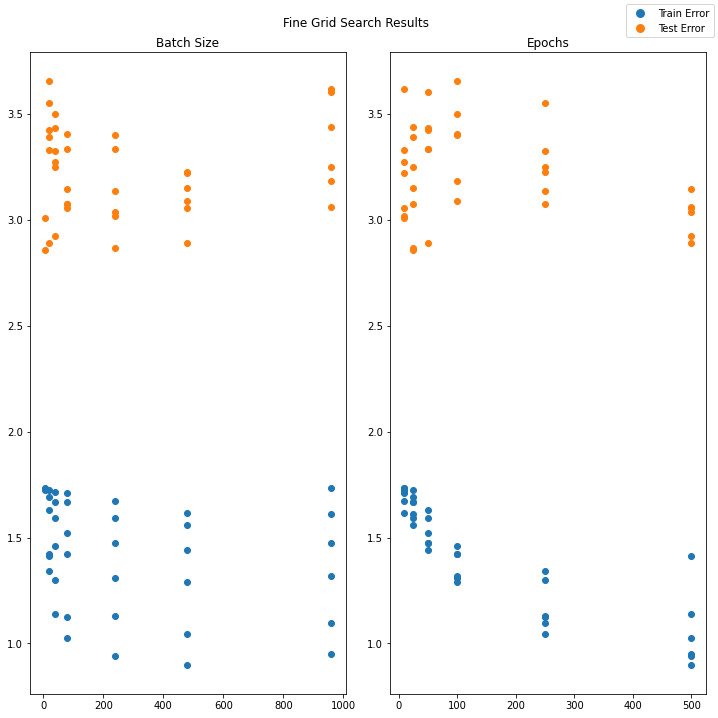

In [23]:
dh.visualizeFineGridSearch(fine_grid_result)

In [24]:
resultdf = dh.resultDFFine(fine_grid_result)

In [25]:
sorted_results = resultdf.sort_values(by=['Test Error'])
sorted_results

,Train Error,Test Error,# Features,# Periods,# Hidden Nodes,# Hidden Layers,Drop Probability,Learning Rate,Clip Size,Batch Size,Epochs
7,1.725942,2.858020,172.0,1.0,10.0,2.0,0.1,0.01,5.0,4.0,25.0
11,1.594068,2.865574,172.0,1.0,10.0,2.0,0.1,0.01,5.0,240.0,25.0
32,1.412882,2.888318,172.0,1.0,10.0,2.0,0.1,0.01,5.0,20.0,500.0
18,1.440423,2.892009,172.0,1.0,10.0,2.0,0.1,0.01,5.0,480.0,50.0
33,1.138091,2.920700,172.0,1.0,10.0,2.0,0.1,0.01,5.0,40.0,500.0
0,1.735800,3.007018,172.0,1.0,10.0,2.0,0.1,0.01,5.0,4.0,10.0
4,1.670275,3.019294,172.0,1.0,10.0,2.0,0.1,0.01,5.0,240.0,10.0
35,0.941609,3.037306,172.0,1.0,10.0,2.0,0.1,0.01,5.0,240.0,500.0
3,1.712163,3.054719,172.0,1.0,10.0,2.0,0.1,0.01,5.0,80.0,10.0
36,0.900002,3.055552,172.0,1.0,10.0,2.0,0.1,0.01,5.0,480.0,500.0


## Evaluate Final Model

In [10]:
#best_model_id = sorted_results.index[0]
#with open(fine_grid_result_dir+str(best_model_id+1)+'.model','rb') as f:
#    model = torch.load(f)
#model.eval()

with open(grid_result_dir+str(325)+'.model','rb') as f:
    model = torch.load(f)
model.eval()

StockLSTM(
  (lstm): LSTM(172, 10, num_layers=2, batch_first=True, dropout=0.1)
  (dropout): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=10, out_features=1, bias=True)
)

Training RMSE: 1.0048796179865285
Test RMSE: 1.2411605118031002
Training MAE: 0.46629497893519495
Test MAE: 0.6532074074718124
Training - Above Error: $0.44 (48.40%) Below Error: $-0.49 (51.60%)
Test - Above Error: $0.42 (62.16%) Below Error: $-1.04 (37.84%)


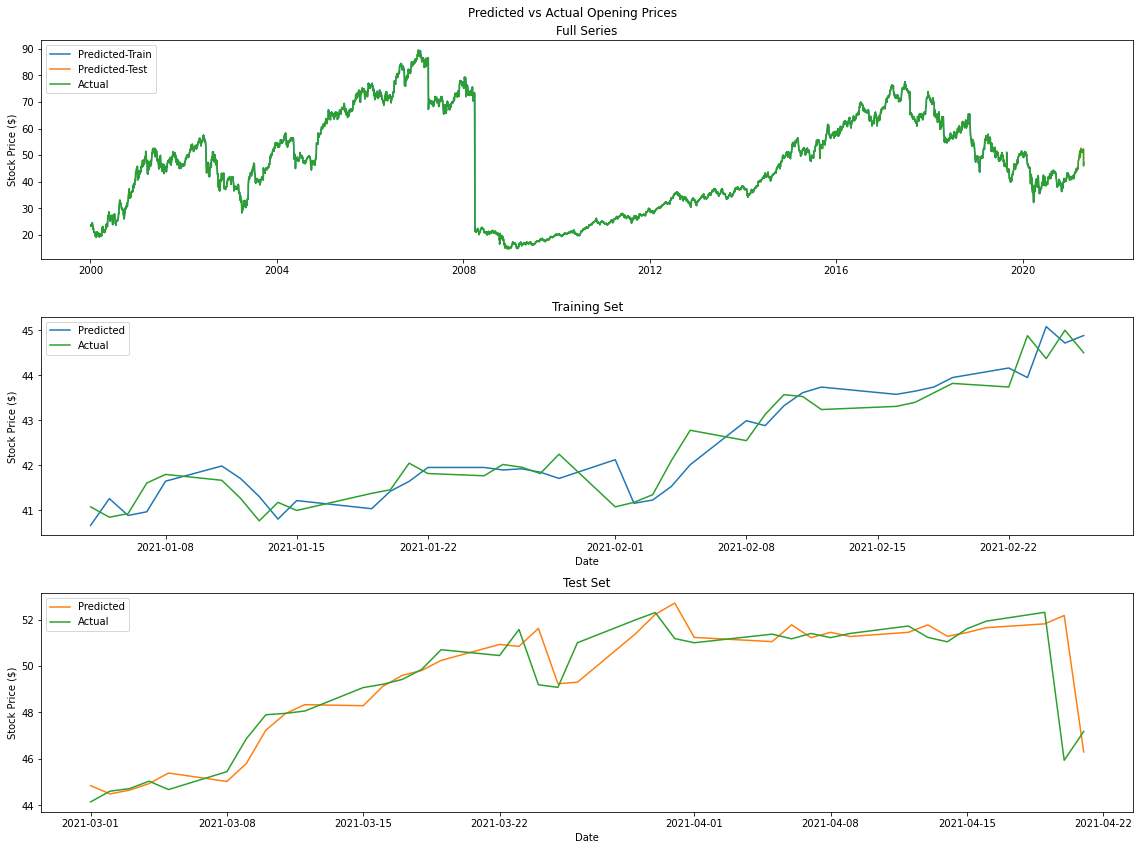

In [11]:
preds = dh.evaluateModel(model=model,
             input_data=df,
             output_data=output_data[:-1],
             scaler=scaler,
             n_steps_in=model.n_periods,
             n_steps_out=1,
             n_test=n_test)

In [12]:
preds.tail()

,Open,Raw_Predictions,Prediction_Type,Predicted
Date,,,,
2021-04-15,51.599998,0.000952,Test,51.438157
2021-04-16,51.930000,-0.002266,Test,51.649108
2021-04-19,52.310001,-0.002616,Test,51.812329
2021-04-20,45.939999,0.007801,Test,52.173165
2021-04-21,47.180000,0.007801,Test,46.298370


In [13]:
with open(pred_dir+tickr+'_pred.bin','wb') as f:
    pickle.dump(preds,f)

In [14]:
with open(final_model_dir+tickr+'_model.model','wb') as f:
    torch.save(model,f)